In [2]:
import datetime

import numpy as np


import spacepy.plot as spp
%matplotlib inline

In [3]:
#  1 YEAR                          I4        
#  2 DOY                           I4        
#  3 Hour                          I3        
#  4 Scalar B, nT                  F6.1      
#  5 BZ, nT (GSM)                  F6.1      
#  6 SW Plasma Speed, km/s         F6.0      
#  7 Dst-index, nT                 I6  

fname = 'omni2_21972.lst'
data = np.loadtxt(fname)
print(data.shape)

(228648, 7)


In [4]:
# make the datetime
tm = data[:,0:3].astype(int)
# year = data[:,0]
# doy = data[:,1]
# hour = data[:,2]

dt = np.asarray([datetime.datetime.strptime('{0:04}{1:03}{2:02}'.format(y,d,h), '%Y%j%H') for y,d,h in tm])

In [5]:
# grab the data into a numpy record array
dtype = [('DT', object), ('B', float), ('Bz', float), ('Vsw', float), ('Dst', int)]
# dat = np.array(data[:,3:], dtype=[('B', float), ('Bz', float), ('Vsw', float), ('Dst', int)])
dat = np.ma.zeros(data.shape[0], dtype=dtype) 
# dat

dat['DT'][:] = dt
dat['B'][:] = np.ma.masked_greater_equal(data[:,3], 999.9)
dat['Bz'][:] = np.ma.masked_greater_equal(data[:,4], 999.9)
dat['Vsw'][:] = np.ma.masked_greater_equal(data[:,5], 9999.)
dat['Dst'][:] = data[:,6]


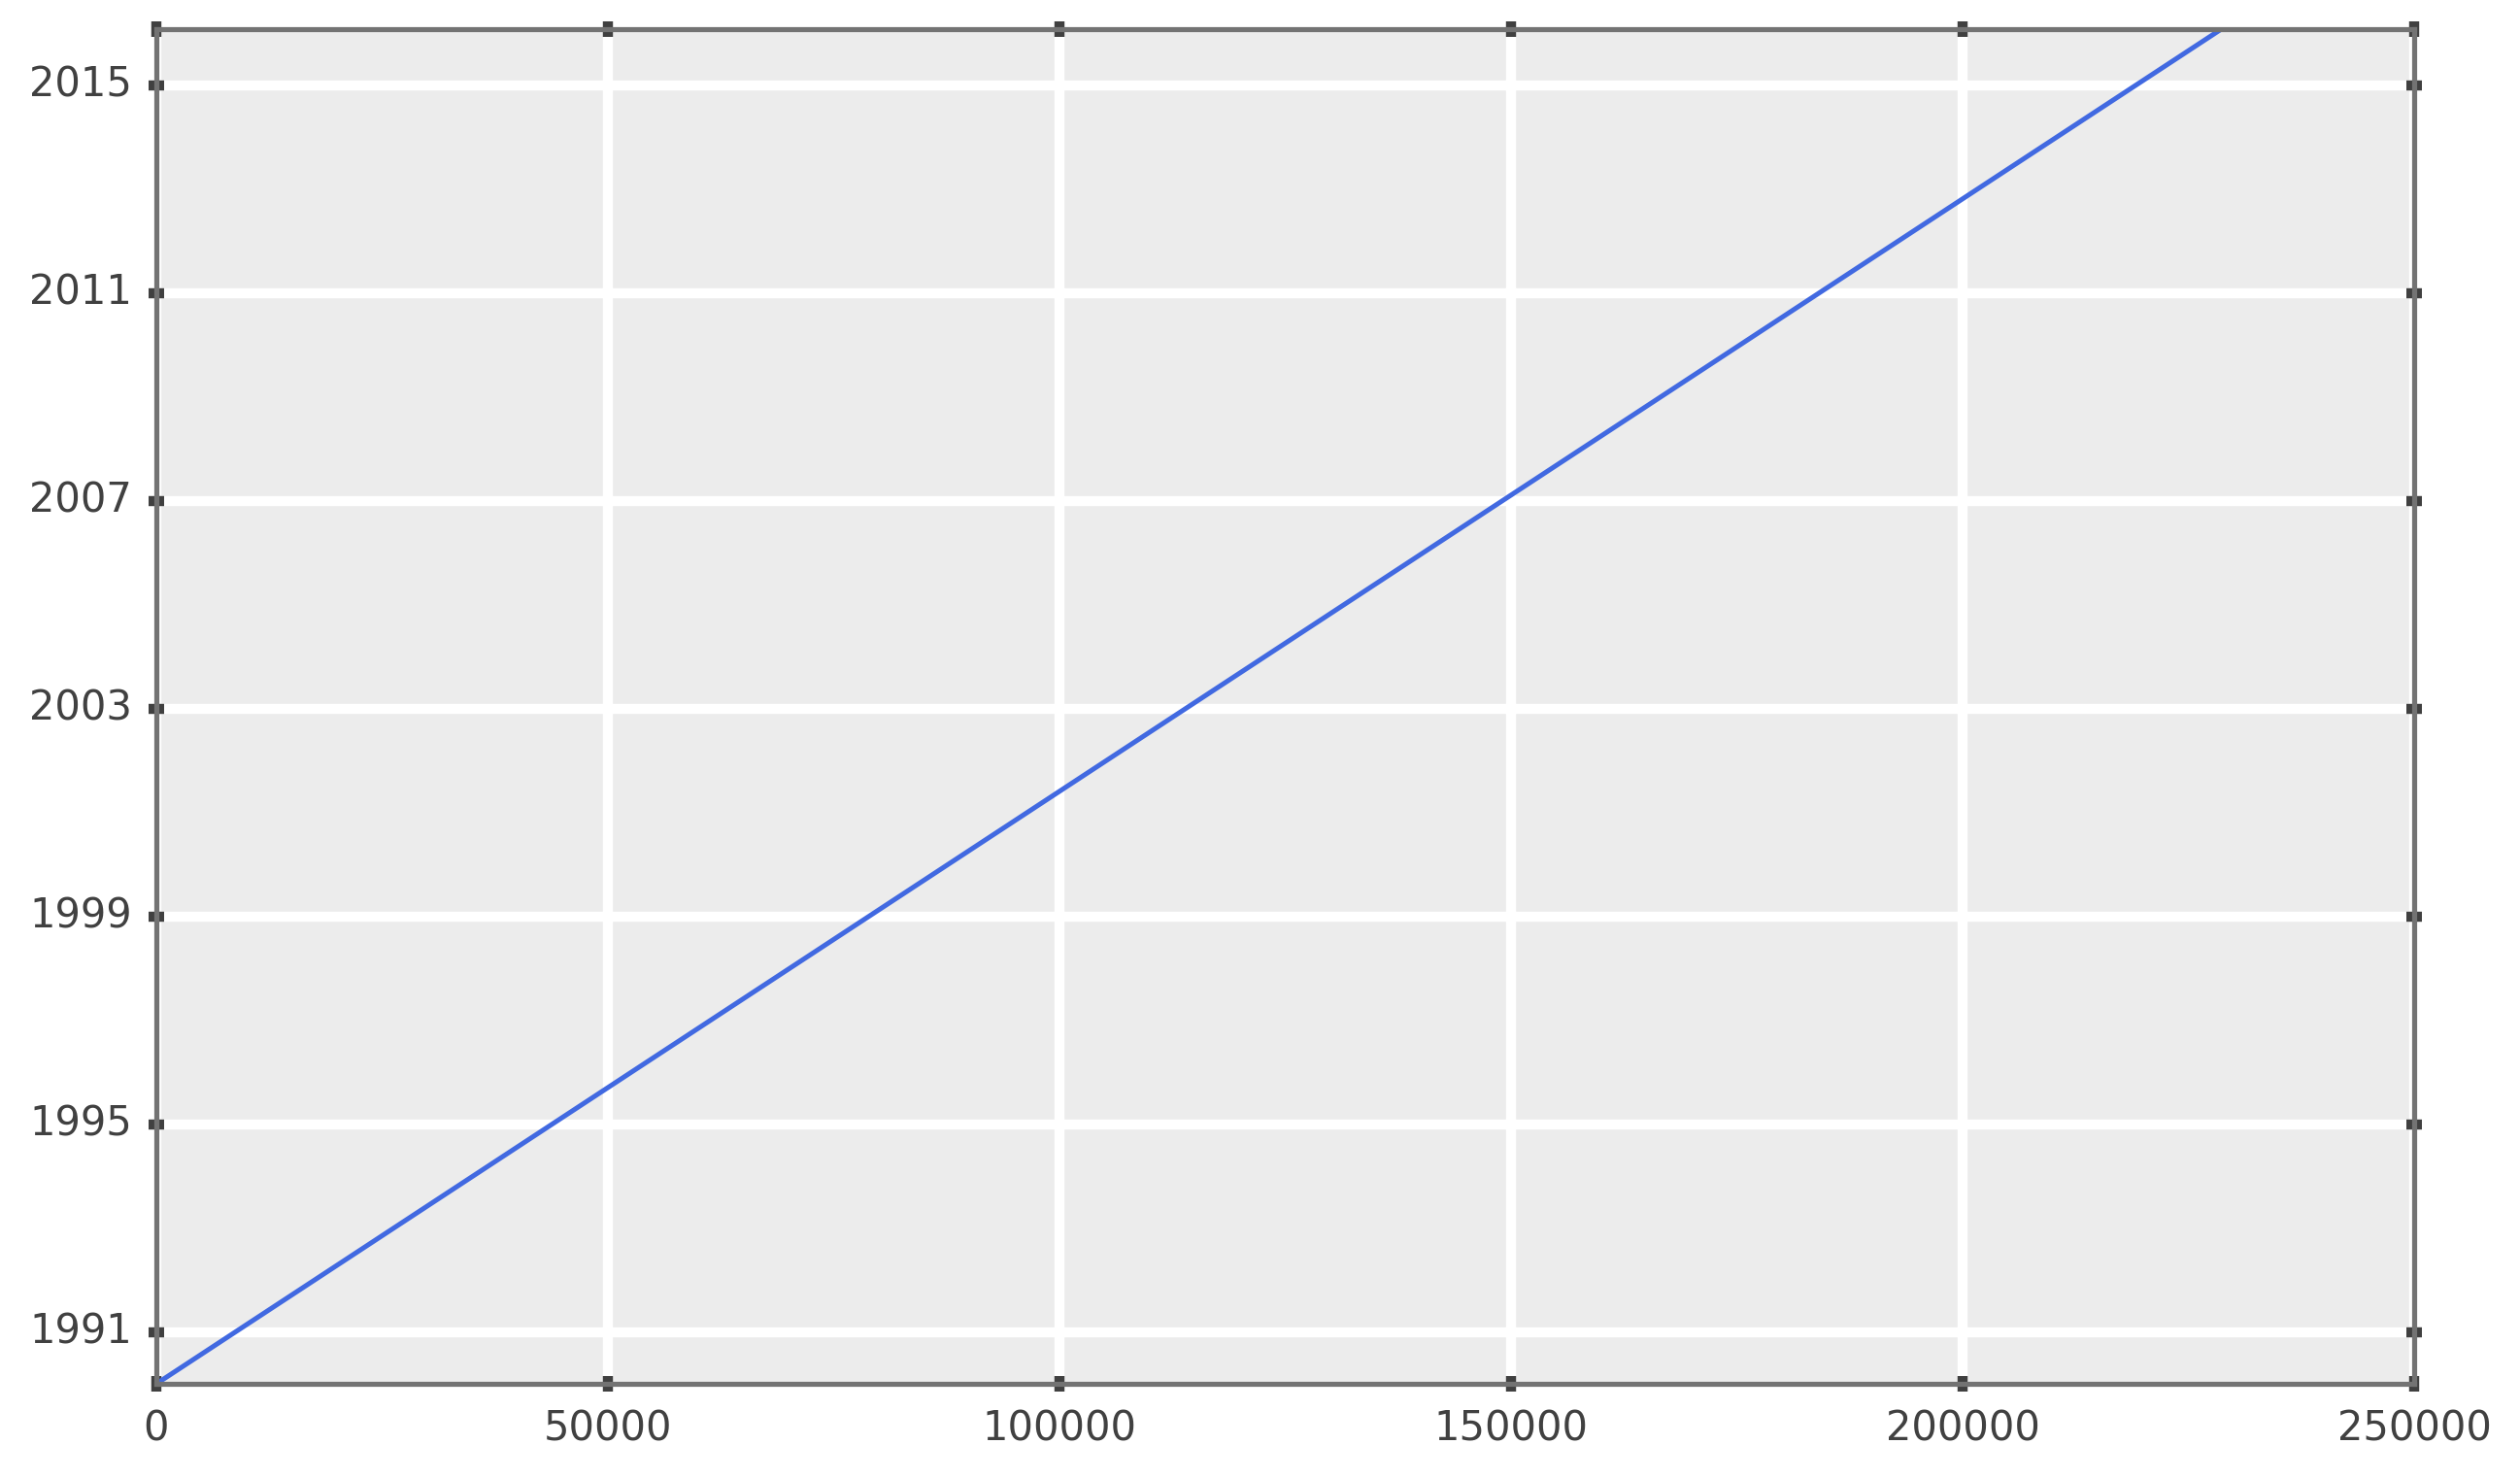

In [6]:
spp.plot(dat['DT'])

In [10]:
print(np.asarray(dat['DT']).min(), np.asarray(dat['DT']).max())
print(np.asarray(dat['DT'])[0:10])

1990-01-01 00:00:00 2016-01-31 23:00:00
[datetime.datetime(1990, 1, 1, 0, 0) datetime.datetime(1990, 1, 1, 1, 0)
 datetime.datetime(1990, 1, 1, 2, 0) datetime.datetime(1990, 1, 1, 3, 0)
 datetime.datetime(1990, 1, 1, 4, 0) datetime.datetime(1990, 1, 1, 5, 0)
 datetime.datetime(1990, 1, 1, 6, 0) datetime.datetime(1990, 1, 1, 7, 0)
 datetime.datetime(1990, 1, 1, 8, 0) datetime.datetime(1990, 1, 1, 9, 0)]


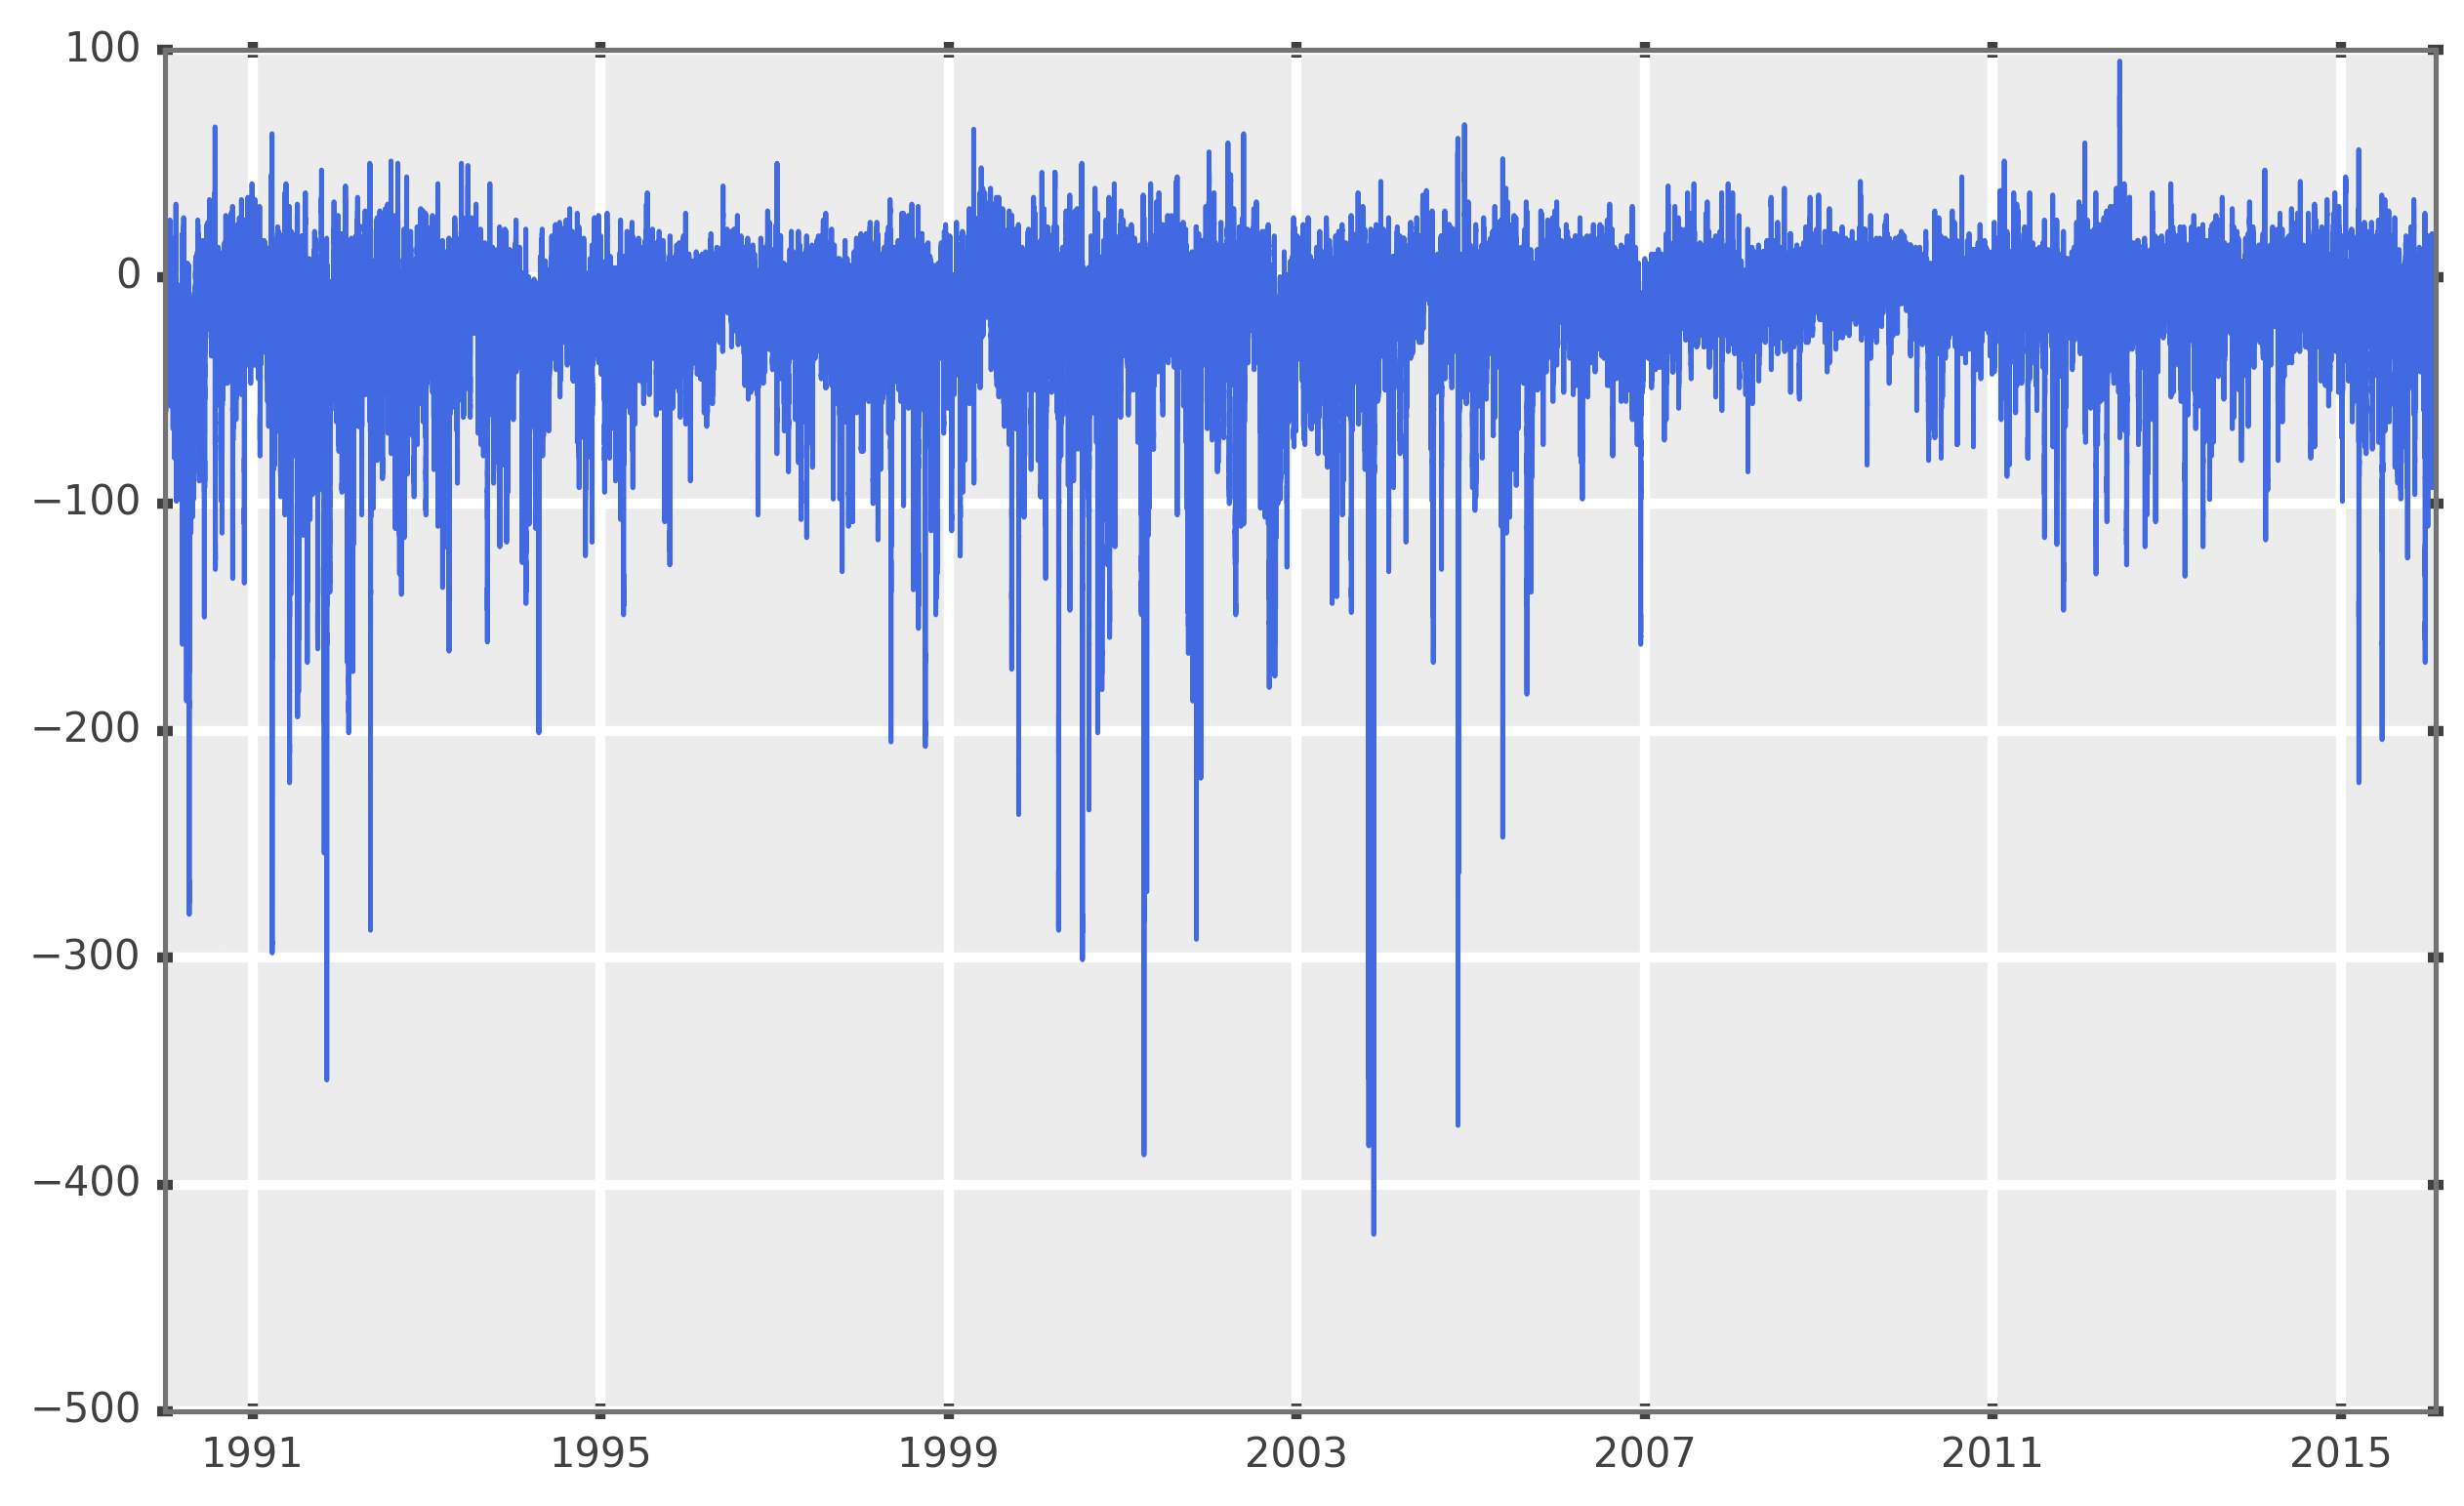

In [7]:
spp.plot(dat['DT'], dat['Dst'])

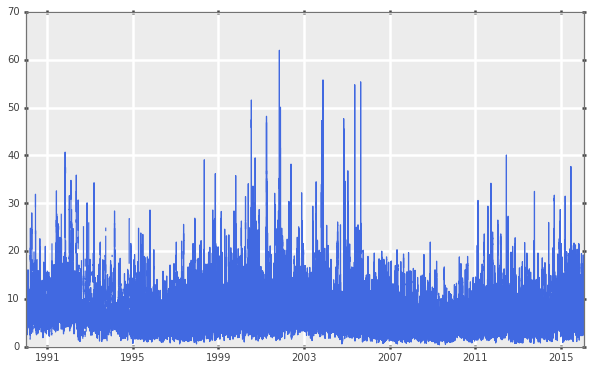

In [10]:
spp.plot(dat['DT'], dat['B'])

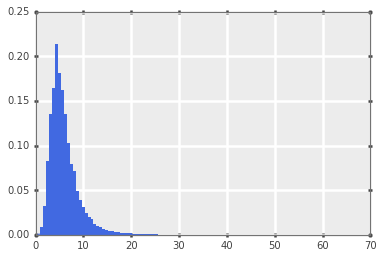

In [11]:
b, h, p = spp.plt.hist(dat['B'].compressed(), 100, normed=True)

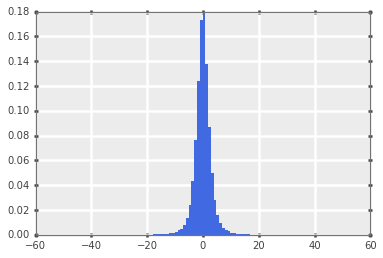

In [12]:
b, h, p = spp.plt.hist(dat['Bz'].compressed(), 100, normed=True)

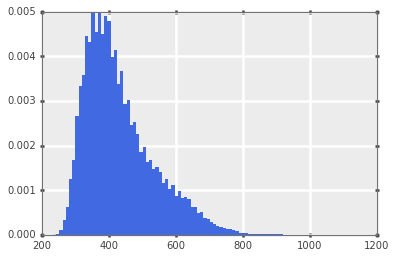

In [13]:
b, h, p = spp.plt.hist(dat['Vsw'].compressed(), 100, normed=True)

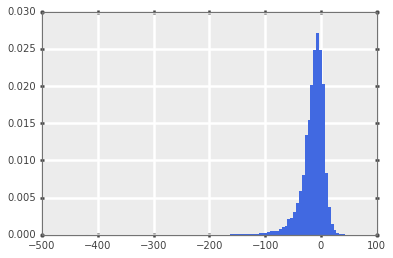

In [14]:
b, h, p = spp.plt.hist(dat['Dst'].compressed(), 100, normed=True)

# Can we do some pymc fitting to the dist?

## it looks like a Gamma for B should work well
params $k=2$, $\theta=2.0$ as a guess

In [15]:
import pymc


In [16]:
shape = pymc.Uniform('shape', 0, 10) # alpha
rate  = pymc.Uniform('rate', 0, 10) # beta
scale = pymc.Uniform('rate', 0, 100)

In [19]:
# B = pymc.Gamma('B', alpha=shape, beta=rate, observed=True, value=scale*dat['B'].compressed())
@pymc.deterministic(plot=False)
def B(alpha=shape, beta=rate, scale=scale):
    return scale*pymc.Gamma('B', alpha=shape, beta=rate, observed=True, value=dat['B'].compressed())


In [20]:
model = pymc.MCMC((shape, rate, B))

In [ ]:
model.sample(iter=10000, burn=1000, verbose=0, progress_bar=1, burn_till_tuned=1)

 [-------          18%                  ] 2659 of 14000 complete in 63.0 sec

In [ ]:
pymc.Matplot.plot(model)